<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Notebooks/13-Perceptron-III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Escuela de Ciencias Físicas y Matemática</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Perceptrón III
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino &bull; 2024-02
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

Este notebook está diseñado como una guía introductoria para implementar un Perceptrón Multiclase. Utilizaremos una clase de Python para construir un modelo que permita clasificar datos en múltiples categorías.



Los paquetes necesarios son:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='html5')


---
## <font color='264CC7'> Ejemplo 1</font>

Generamos datos de clasificación sintéticos con la función `make_blobs` de la librería `sklearn.datasets`.

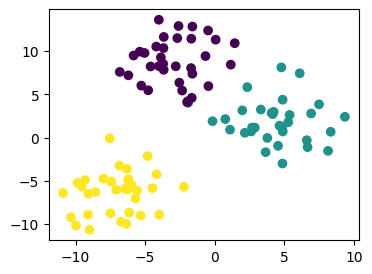

In [2]:
# Generamos los datos
X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=42, cluster_std=2.5)

# Visualizar los datos
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Consideremos, primero, que a nuestros datos agregamos una columna de unos para el sesgo. De esta forma, el vector de pesos $w$ incluirá el sesgo $b$. Así, en lugar de calcular $a = w \cdot x + b$, calcularemos $a = w \cdot x$.

Con esto, podemos definir las siguientes funciones para el Perceptrón Multiclase:

- **Función de combinación**: $ a_k(w_k, x) = w_k x $
- **Función de activación** (Softmax):  
  $$
  \sigma_k(a) = \frac{e^{a_k}}{\sum_{j} e^{a_j}}
  $$  
- **Salida del perceptrón**:  
  $$
  \hat{y} = (\hat{y}_k)_{k=1,\ldots,C} = (\sigma_k(a))_{k=1,\ldots,C}
  $$  
- **Función de pérdida** (Categorical Cross-Entropy):  
  $$
  \displaystyle L(\hat{y}, y) = -\frac{1}{N} \sum_{k=1}^C y_k \log(\hat{y}_k)
  $$  
  donde $ C $ es el número de clases y $ y_{k}^{(i)} $ es un indicador que vale 1 si la muestra $ i $ pertenece a la clase $ k $, y 0 en caso contrario.

Calculamos el gradiente de la función de pérdida respecto a los pesos $ w_k $ para cada clase $ k $:
$$\begin{aligned}
    \frac{\partial L}{\partial w} & 
    = \frac{\partial L}{\partial \hat{y}}\cdot \frac{\partial \hat{y}}{\partial a} \cdot\frac{\partial a}{\partial w}\\
    &= \frac{\partial L}{\partial \hat{y}}\cdot \text{J}_{\sigma}(a) \cdot\frac{\partial a}{\partial w},
\end{aligned}$$
o, de otra forma:
$$\begin{aligned}
\frac{\partial L}{\partial w_k}  
    &= \sum_{j=1}^C \frac{\partial L}{\partial \hat{y}_j} \frac{\partial \hat{y}_j}{\partial w_k}\\
    &= \sum_{j=1}^C \frac{\partial L}{\partial \hat{y}_j} \frac{\partial \hat{y}_j}{\partial a_k} \frac{\partial a_k}{\partial w_k}
\end{aligned}$$
El valor de cada derivada parcial es:
$$\begin{aligned}
    \frac{\partial a_k}{\partial w_k} &= x,\\
    \frac{\partial \hat{y}_j}{\partial a_k} &= \text{J}_{\sigma}(a)_{jk} = \sigma_k(a)(\delta_{jk} - \sigma_j(a)),\\
    \frac{\partial L}{\partial \hat{y}_j} &= - \frac{y_j}{\hat{y}_j}.
\end{aligned}$$
Por lo tanto, el gradiente de la función de costo respecto a los pesos $w_k$ es:
$$
\frac{\partial L}{\partial w_k} = \frac{1}{N} \sum_{i=1}^N \left( \hat{y}_k^{(i)} - y_k^{(i)} \right) x^{(i)}
$$

Definimos las funciones y sus derivadas:

In [3]:
import numpy as np

# Funciones de pérdida
def ce(y, y_hat):
    y_one_hot = np.zeros_like(y_hat)
    y_one_hot[np.arange(len(y)), y] = 1
    return -np.sum(y_one_hot * np.log(y_hat + 1e-8)) / len(y)

# Funciones de activación
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Perceptrón
class Perceptron():
    def __init__(self, inputs, outputs, activation, loss):
        self.size = (inputs, outputs)
        self.ws = []
        self.activation = activation
        self.loss = loss
        self.losses = []

    def __call__(self, X):
        return self.activation(np.dot(X, self.w)) # y_hat

    def fit(self, X, y, lr=0.1, epochs=20, verbose=True, random_state=42, log_each=5):
        np.random.seed(random_state)
        self.w = np.random.rand(self.size[0] + 1, self.size[1])
        X = np.c_[np.ones(len(X)), X]  # Agregar sesgo
        for epoch in range(epochs):
            y_hat = self(X)
            self.losses.append(self.loss(y, y_hat))
            y_one_hot = np.zeros_like(y_hat)
            y_one_hot[np.arange(len(y)), y] = 1
            dLdw = np.dot(X.T, y_hat - y_one_hot) / len(y)
            self.w -= lr * dLdw
            self.ws.append(self.w.copy())
            if verbose and not epoch % log_each:
                print(f"Epoch {epoch}/{epochs} Loss {self.losses[-1]}")
        if verbose:
            print(f'\nFinal. Epoch {epochs}, Loss: {self.losses[-1]}')

    def predict(self, X):
        X = np.c_[np.ones(len(X)), X]  # Agregar sesgo
        return self(X)


### <font color='264CC7'> Modelo y entrenamiento </font>

Definamos el modelo y entrenamos el perceptrón:

In [4]:
# Definimos el modelo
modelo = Perceptron(inputs=2, outputs=3, activation=softmax, loss=ce)

# Entrenamos el modelo
modelo.fit(X, y, lr=0.1, epochs=20)

Epoch 0/20 Loss 3.8502144782908214
Epoch 5/20 Loss 0.1522830578051952
Epoch 10/20 Loss 0.11137474790988307
Epoch 15/20 Loss 0.09670733587661026

Final. Epoch 20, Loss: 0.0899875828080345


Visualicemos el entrenamiento:

In [5]:
# Configuración inicial de la figura y subplots
fig, (ax_loss, ax_modelo) = plt.subplots(1, 2, figsize=(10, 4))

# Graficar la función de pérdida
epochs = np.arange(len(modelo.ws))
ax_loss.plot(epochs, modelo.losses)
ax_loss.set_title('Función de costo')
ax_loss.set_xlabel('Épocas')
ax_loss.set_ylabel('Costo')
scatter_loss = ax_loss.scatter([], [], s=50)

# Crear un grid para las regiones de decisión
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 200))

# Graficar los datos
scatter = ax_modelo.scatter(X[:, 0], X[:, 1], c=y)
ax_modelo.set_title('Modelo')
texto_epoca = ax_modelo.text(0.7, 0.9, '', transform=ax_modelo.transAxes)

# Función de actualización para la animación
contour_plot = None
def actualizar(frame):
    global contour_plot  # Necesitamos acceder a la referencia global
    if contour_plot:
        for c in contour_plot.collections:
            c.remove()  # Eliminar contornos previos

    w = modelo.ws[frame]
    Z = np.c_[xx.ravel(), yy.ravel()]  # Grid de puntos
    Z = np.c_[np.ones(len(Z)), Z]     # Agregar sesgo
    preds = modelo.activation(np.dot(Z, w))  # Predicciones de softmax
    Z = np.argmax(preds, axis=1).reshape(xx.shape)  # Clase con mayor probabilidad
    contour_plot = ax_modelo.contourf(xx, yy, Z, alpha=0.5)  # Regiones de decisión
    
    scatter_loss.set_offsets(np.array([[epochs[frame], modelo.losses[frame]]]))
    texto_epoca.set_text(f'Época: {frame + 1}/{len(modelo.ws)}\nPérdida: {modelo.losses[frame]:.4f}')
    return scatter_loss, texto_epoca

# Crear y configurar la animación
animacion = FuncAnimation(
    fig, actualizar, frames=len(modelo.ws),
    interval=300, blit=False, repeat=False
)

plt.tight_layout()
plt.close()
animacion


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Prueba algunos hiperparámetros y observa cómo cambia el entrenamiento.
<ul>
  <li>Selecciona una tasa de aprendizaje muy pequeña y observa cómo cambia el entrenamiento.</li>
  <li>Selecciona una tasa de aprendizaje muy grande y observa cómo cambia el entrenamiento.</li>
</ul>
</div>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Aumenta la varianza de los datos hasta que no se pueda separar linealmente, observa cómo cambia el entrenamiento.
</div>

### <font color='264CC7'> Predicción </font>

Realizamos la predicción usando el modelo entrenado:

[[2.78276861e-01 1.33154387e-02 7.08407700e-01]
 [9.97185822e-01 5.07121624e-04 2.30705687e-03]
 [1.28125329e-03 9.65259623e-01 3.34591238e-02]]
[2 0 1]


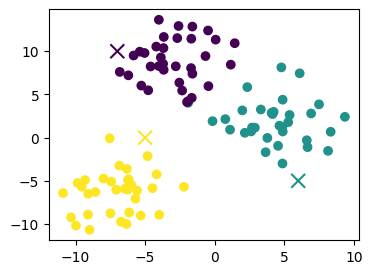

In [6]:
# Nuevos datos aleatorios
X_test = np.array([[-5,0], [-7,10],[6,-5]])

# Predicciones
y_pred = modelo.predict(X_test)
print(y_pred)

# Tomo el argumento máximo
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

# Visualizar los datos
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, marker='x', s=100)
plt.show()


#